In [1]:
import invisible_cities.io.rwf_io as rwfio

In [2]:
import sys
import os
import shutil
import functools
import time
import glob

%matplotlib inline
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import pandas as pd

Running on  Thu Apr 11 16:05:05 2019


In [3]:
from matplotlib import pylab as plt

In [4]:
import numpy  as np
import tables as tb
import pandas as pd

from invisible_cities.types.ic_types import minmax
from invisible_cities.database       import load_db

from invisible_cities.core.system_of_units_c import units

from invisible_cities.reco                  import tbl_functions        as tbl
from invisible_cities.reco                  import  peak_functions      as pkf
from invisible_cities.core.random_sampling  import NoiseSampler         as SiPMsNoiseSampler
from invisible_cities.io  .        pmaps_io import          pmap_writer
from invisible_cities.io.        mcinfo_io  import       mc_info_writer
from invisible_cities.io  .run_and_event_io import run_and_event_writer
from invisible_cities.io  .trigger_io       import       trigger_writer
from invisible_cities.io  .event_filter_io  import  event_filter_writer

from invisible_cities.dataflow            import dataflow as fl
from invisible_cities.dataflow.dataflow   import push
from invisible_cities.dataflow.dataflow   import pipe
from invisible_cities.dataflow.dataflow   import sink

from invisible_cities.cities.components import city
from invisible_cities.cities.components import print_every
from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms
from invisible_cities.cities.components import zero_suppress_wfs
from invisible_cities.cities.components import WfType
from invisible_cities.cities.components import wf_from_files
# dorothea
from invisible_cities.cities.components      import peak_classifier
from invisible_cities.filters.s1s2_filter    import S12Selector
from invisible_cities.cities.components             import peak_classifier

from   invisible_cities.cities.irene       import build_pmap
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io          as dsts

from invisible_cities.icaro.hst_functions  import hist2d, hist2d_profile
from invisible_cities.core.fit_functions   import  *

import invisible_cities.core.fit_functions as fitf

## Open Dorothea Kr file:

In [5]:
demopp  = os.environ['ICTDIR'] + '/invisible_cities/database/localdb.DEMOPPDB.sqlite3'

In [6]:
demopp

'/Users/neus/IC/invisible_cities/database/localdb.DEMOPPDB.sqlite3'

In [7]:
sipm = load_db.DataSiPM(load_db.DetDB.demopp,533)

In [8]:
demopp

'/Users/neus/IC/invisible_cities/database/localdb.DEMOPPDB.sqlite3'

### Open files:

In [9]:
path = '/Users/neus/current-work/data/533/kdst/trigger1/'

In [10]:
files_all = [path+f for f in os.listdir(path) if os.path.isfile( os.path.join(path, f) )]

In [11]:
d = dsts.load_dsts(files_all, "DST", "Events")

In [12]:
len(d),type(d)

(10677286, pandas.core.frame.DataFrame)

In [13]:
d.dtypes.index

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [14]:
d.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,504466.0,1.554834e+09,0.0,0.0,1.0,2.0,300.0,2.725628,15.737635,179825.0,...,13.0,224.660080,224.660080,1.821925,-27.675439,-65.257310,70.883330,-1.971902,9.912184,7.173162
1,504466.0,1.554834e+09,0.0,1.0,1.0,2.0,300.0,2.725628,15.737635,179825.0,...,3.0,405.623718,405.623718,1.342190,75.000000,-63.101461,98.014256,-0.699452,0.000000,5.348041
2,504467.0,1.554834e+09,0.0,0.0,1.0,2.0,325.0,3.551071,17.735647,267275.0,...,4.0,136.212280,136.212280,1.645606,-75.000000,2.305475,75.035426,3.110863,0.000000,11.629563
3,504467.0,1.554834e+09,0.0,1.0,1.0,2.0,325.0,3.551071,17.735647,267275.0,...,9.0,160.240356,160.240356,1.686990,-68.357803,-13.708537,69.718816,-2.943677,5.955041,7.428572
4,504468.0,1.554834e+09,0.0,0.0,1.0,1.0,175.0,3.749980,15.710565,76550.0,...,16.0,327.946045,327.946045,2.129636,-54.457987,-11.343562,55.626871,-2.936230,9.993913,9.991112


In [15]:
d.tail()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
1256,1792788.0,1.554854e+09,0.0,1.0,1.0,3.0,325.0,13.914890,76.209473,173375.0,...,49.0,242.113388,242.113388,2.037833,56.559050,-44.362185,71.881357,-0.665126,23.352653,18.786566
1257,1792788.0,1.554854e+09,0.0,2.0,1.0,3.0,325.0,13.914890,76.209473,173375.0,...,106.0,524.114624,524.114624,5.268925,33.231127,56.636099,65.665481,1.040178,24.781940,27.095883
1258,1792790.0,1.554854e+09,0.0,0.0,1.0,2.0,425.0,4.686235,35.749504,167100.0,...,7.0,237.364487,237.364487,1.804588,-66.198208,53.852184,85.336162,2.458675,6.253144,6.204204
1259,1792790.0,1.554854e+09,0.0,1.0,1.0,2.0,425.0,4.686235,35.749504,167100.0,...,17.0,259.380676,259.380676,1.932160,-62.713618,61.703939,87.979395,2.364310,9.723107,9.154901
1260,1792791.0,1.554854e+09,0.0,0.0,1.0,1.0,350.0,4.971952,30.979445,218950.0,...,10.0,186.514984,186.514984,1.796127,-62.335551,55.779749,83.648678,2.411641,7.768103,7.106380


## Selection:

In [16]:
sel = (d.nS1 == 1) & (d.Z<350) 
sel2 = (d.nS1 == 1) & (d.nS2 == 1) & (d.Z < 350)  
sel3 = (d.nS1 == 1) & (d.nS2 == 1) & (d.Z < 300) & (d.Z > 20)  & (d.R<60)

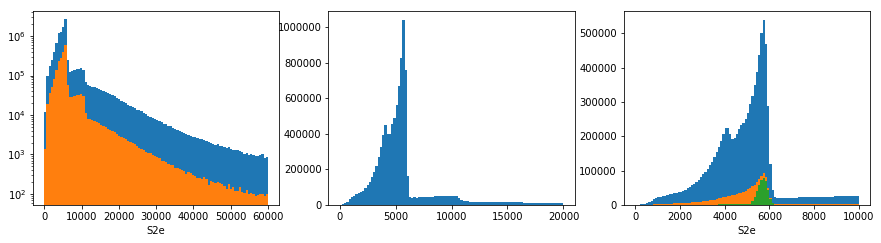

In [31]:
fig = plt.figure(figsize = (15,25))

ax2 = fig.add_subplot(6,3,1)
plt.hist(d.S2e     ,100,[0,60000])
plt.hist(d.S2e[sel],100,[0,60000])
plt.yscale('log', nonposy='clip')
plt.xlabel('S2e')

ax2 = fig.add_subplot(6,3,2)
plt.hist(d.S2e,     100,[0,20000])

ax2 = fig.add_subplot(6,3,3)
plt.hist(d.S2e,     100,[0,10000])
plt.hist(d.S2e[sel2],100,[0,10000])
plt.hist(d.S2e[sel3],100,[0,10000])
plt.xlabel('S2e')

plt.show()

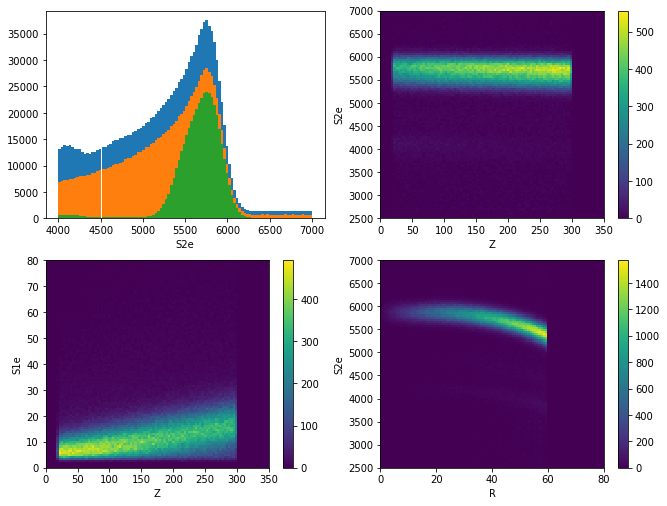

In [18]:
fig = plt.figure(figsize = (11,13))

ax2 = fig.add_subplot(3,2,1)
#plt.hist(d.S2e, 100, [4000,7000])
plt.hist(d.S2e[sel], 100, [4000,7000])
plt.hist(d.S2e[sel2], 100, [4000,7000])
plt.hist(d.S2e[sel3], 100, [4000,7000])
plt.xlabel('S2e')

ax2 = fig.add_subplot(3,2,2)
plt.hist2d(d.Z[sel3], d.S2e[sel3],[100,100],[[0,350],[2500,7000]])
plt.xlabel('Z')
plt.ylabel('S2e')
plt.colorbar()

ax2 = fig.add_subplot(3,2,3)
plt.hist2d(d.Z[sel3], d.S1e[sel3],[100,100],[[0,350],[0,80]])
plt.xlabel('Z')
plt.ylabel('S1e')
plt.colorbar()

ax2 = fig.add_subplot(3,2,4)
plt.hist2d(d.R[sel3], d.S2e[sel3],[100,100], [[0,80],[2500, 7000]])
plt.xlabel('R')
plt.ylabel('S2e')
plt.colorbar()

plt.show()

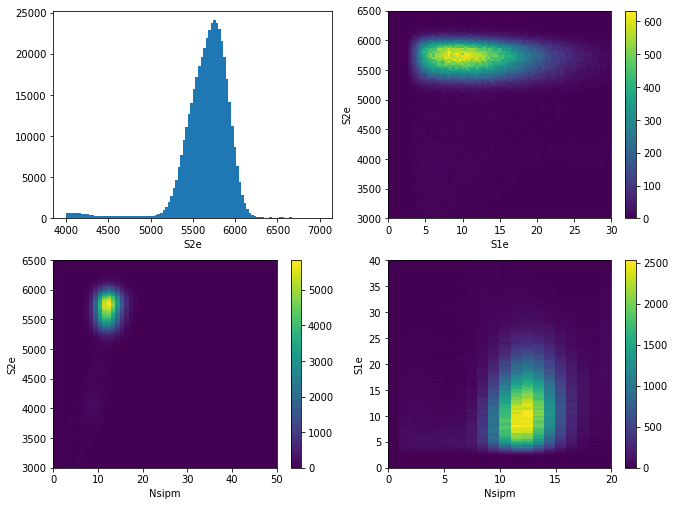

In [22]:
fig = plt.figure(figsize = (11,13))

ax2 = fig.add_subplot(3,2,1)
plt.hist(d.S2e[sel3],100,[4000,7000])
plt.xlabel('S2e')

ax2 = fig.add_subplot(3,2,2)
plt.hist2d(d.S1e[sel3], d.S2e[sel3], 100, [[0,30], [3000,6500]])
plt.xlabel('S1e')
plt.ylabel('S2e')
plt.colorbar()

ax2 = fig.add_subplot(3,2,3)
plt.hist2d(d.Nsipm[sel3], d.S2e[sel3], [50, 100], [[0,50],[3000,6500]])
plt.xlabel('Nsipm')
plt.ylabel('S2e')
plt.colorbar()

ax2 = fig.add_subplot(3,2,4)
plt.hist2d(d.Nsipm[sel3],d.S1e[sel3], [20, 100], [[0,20],[0,40]])
plt.xlabel('Nsipm')
plt.ylabel('S1e')
plt.colorbar()

plt.show()

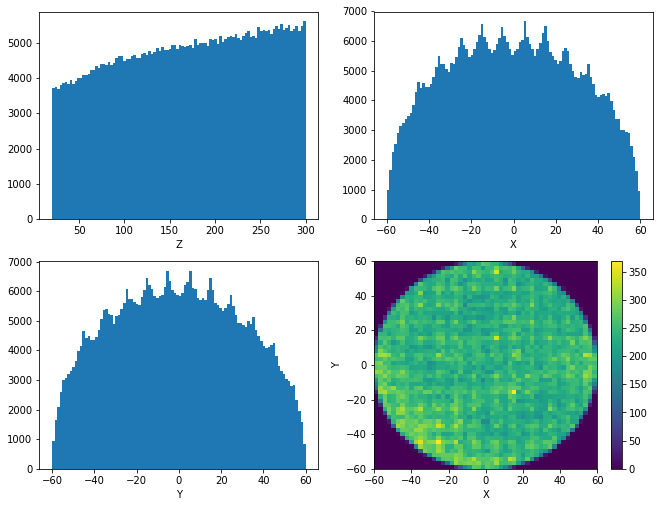

In [20]:
fig = plt.figure(figsize = (11,13))

ax2 = fig.add_subplot(3,2,1)
plt.hist(d.Z[sel3],100)
#plt.yscale('log', nonposy='clip')
plt.xlabel('Z')

ax2 = fig.add_subplot(3,2,2)
plt.hist(d.X[sel3],100)
#plt.yscale('log', nonposy='clip')
plt.xlabel('X')

ax2 = fig.add_subplot(3,2,3)
plt.hist(d.Y[sel3],100)
#plt.yscale('log', nonposy='clip')
plt.xlabel('Y')

ax2 = fig.add_subplot(3,2,4)
plt.hist2d(d.X[sel3], d.Y[sel3],50)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

plt.show()